In [ ]:
"""
<순환신경망 종류>
 * 심플 순환신경망(Simple RNN) 단점
  - 긴 문장(단어의 갯수가 많은 경우)을 학습하기 어려움
  - 문장이 길 수록(단어의 갯수가 많을수록) 초반의 정보(단어를 의미함)는 점진적으로 희석(소멸)됨
  - 즉, 멀리 떨어져 있는 단어의 정보를 인식하는데 어려움이 있음
    (문장의 앞뒤 문맥(단어를 의미함) 데이터의 기억이 단기기억으로 저장됨)
  - 이러한 단점을 보완한 모델이 LSTM 임
 
 * 장기기억 순환신경망(Long Shot-Term Memory, LSTM)
  - Simple RNN의 단점을 보완한 모델
  - 단기기억을 오래 기억할 수 있도록 고안된 모델
  - 많은 이전 단어들의 정보를 기억해야 하기 때문에 훈련 속도가 느림(단점)
  - 시스템 저장 공간이 많이 필요함(단점)
 
 * 게이트웨이 반복 단위 순환신경망(Gated Recurrent Unit, GRU)
  - LSTM의 장기기억 순환신경망의 개념을 그대로 적용하고, 단점을 보완한 모델
  - 너무 오래된 기억은 서서히 소멸해 나가면서, 최근 기억을 지속적으로 유지하는 방식을 사용함
  - 성능은 LSTM과 동일 (속도를 빠르게 하기 위한 모델임)
 
 *** RNN 순환신경망 모델들은 주로, RMSprop 옵티마이저를 사용함
"""

### 라이브러리 정의

In [61]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, SimpleRNN, Embedding, LSTM, GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

### 텍스트 길이 정규화 라이브러리
# - 텍스트의 길이가 긴 경우에는 자르고, 길이가 짧은 경우에는 채움
from tensorflow.keras.preprocessing.sequence import pad_sequences


tf.keras.utils.set_random_seed(42)

### 사용할 데이터셋
# - 영화 리뷰 감상평 데이터(긍정/부정)
from keras.datasets import imdb

In [2]:
### 데이터 수집
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

print(train_input.shape, train_target.shape)
print(test_input.shape, test_target.shape)

(25000,) (25000,)
(25000,) (25000,)


### 훈련 : 검증 = 8 : 2 로 분리하기

In [3]:
### 변수명 : train_input, train_target, val_input, val_target
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)

print(train_input.shape, train_target.shape)
print(val_input.shape, val_target.shape)
print(test_input.shape, test_target.shape)

(20000,) (20000,)
(5000,) (5000,)
(25000,) (25000,)


In [4]:
### 모든 데이터의 문장 길이를 확인하여 가장 많이 분포하는 위치를 기준으로 통일시키는 처리를 진행

### 훈련 독립변수의 각 문장데이터들의 문장길이(단어의 갯수)를 확인하여,
# - 하나의 배열에 저장하기
# - 변수명 : lengths
print(len(train_input), len(train_input[0]))

lengths = np.array([ len(x) for x in train_input ])

print(lengths)
print(lengths.shape)

20000 259
[259 520 290 ... 300  70  77]
(20000,)


In [5]:
### 훈련 데이터 스케일링
train_seq = pad_sequences(train_input, maxlen=100)
print(train_seq.shape, train_target.shape)

### 검증 데이터 스케일링
val_seq = pad_sequences(val_input, maxlen=100)
print(val_seq.shape, val_target.shape)

(20000, 100) (20000,)
(5000, 100) (5000,)


### 데이터 스케일링 하기(단어 길이 표준화하기)

In [6]:
### 텍스트 제거 또는 채우기 속성 추가
"""
<제거 및 채우기 속성>
 * truncating : maxlen보다 클 때 자르기 속성
  - truncating = "pre" : 앞쪽 제거(기본값으로 사용됨, 생략가능)
  - truncating = "post" : 뒤쪽 제거
  
 * padding : maxlen보다 작을 때 채우기 속성
  - padding = "pre" : 앞쪽을 0으로 채우기(기본값으로 사용됨, 생략가능)
  - padding = "post" : 뒤쪽을 0으로 채우기
"""

### 훈련 데이터 스케일링
train_seq = pad_sequences(train_input, maxlen=100, truncating="post", padding="post")
print(train_seq.shape, train_target.shape)

### 검증 데이터 스케일링
val_seq = pad_sequences(val_input, maxlen=100, truncating="post", padding="post")
print(val_seq.shape, val_target.shape)


(20000, 100) (20000,)
(5000, 100) (5000,)


### LSTM 훈련 모델 생성하기

In [ ]:
### 모델 생성하기
model = Sequential([
    # 입력계층 (입베딩 계층) 추가하기
    Embedding(
        input_dim = 500,            # 말뭉치 값
        output_dim = 16,            # 주요 몇개 뽑을건지
        input_length = 100          # 
    ),
    # 은닉계층 (LSTM 계층) 추가하기 : RNN모델의 이름만 바꿔주면 됩니다.
    LSTM(
        units = 8
    ),
    
    # 출력계층 추가하기
    Dense(
        units = 1,
        activation = "sigmoid"
    )
])

In [12]:
model.summary()

"""
<Param 계산공식>
 * embedding = 말뭉치갯수 * 출력갯수 = 500 * 16 = 8,000
 
 * LSTM = 가중치 세트 갯수 * (출력갯수 * (입력갯수 + 출력갯수 + 1))
        = 4 * (8 * (16 + 8 + 1)) = 800
        
<가중치 세트 설명>
  - 총 4개의 세트로 구성되어 있음(이떄 세트를 -> 게이트라고 칭하기도 합니다.)
  
 * 셀상태관리
  - LSTM의 장기 기억을 담당
  - 셀 상태는 정보를 장기간 동안 유지할 수 있도록 관리됨
  - 입력/망각/출력 게이트를 통해서 셀 상태 정보가 업데이트 됩니다.
 
 * 입력게이트
  - 현재 시점의 입력 데이터가 셀 상태에 얼마나 반영될지를 결정
  - 새로운 정보를 얼마나 저장할지를 조절하는 역할을 수행
 
 * 망각게이트
  - 이전 셀 상태에서 얼마나 많은 정보를 잊어버릴지 결정
  - 이전 상태의 정보를 얼마나 제거할지를 조절하는 역할
 
 * 출력게이트
  - 셀 상태에서 어떤 정보를 출력할지 결정
  - 셀 상태를  현재 시점의 출력으로 변환하는 역할
 
 * 가중치 업데이트 : 위 4개의 가중치 세트가 동시에 작동하면서
                    출력에 가장 가까운 단어 조합을 만들어 냄...
"""

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


'\n<Param 계산공식>\n * embedding = 말뭉치갯수 * 출력갯수 = 500 * 16 = 8,000\n \n * LSTM = 가중치 세트 갯수 * (출력갯수 * (입력갯수 + 출력갯수 + 1))\n        = 4 * (8 * (16 + 8 + 1)) = 800\n        \n<가중치 세트 설명>\n  - 총 4개의 세트로 구성되어 있음(이떄 세트를 -> 게이트라고 칭하기도 합니다.)\n  \n * 셀상태관리\n  - LSTM의 장기 기억을 담당\n  - 셀 상태는 정보를 장기간 동안 유지할 수 있도록 관리됨\n  - 입력/망각/출력 게이트를 통해서 셀 상태 정보가 업데이트 됩니다.\n \n * 입력게이트\n  - 현재 시점의 입력 데이터가 셀 상태에 얼마나 반영될지를 결정\n  - 새로운 정보를 얼마나 저장할지를 조절하는 역할을 수행\n \n * 망각게이트\n  - 이전 셀 상태에서 얼마나 많은 정보를 잊어버릴지 결정\n  - 이전 상태의 정보를 얼마나 제거할지를 조절하는 역할\n \n * 출력게이트\n  - 셀 상태에서 어떤 정보를 출력할지 결정\n  - 셀 상태를  현재 시점의 출력으로 변환하는 역할\n \n * 가중치 업데이트 : 위 4개의 가중치 세트가 동시에 작동하면서\n                    출력에 가장 가까운 단어 조합을 만들어 냄...\n'

### 훈련모델 설정하기(compile)

In [8]:
### RMSprop 사용, 학습율 0.0001 사용, 정확도 출력
model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate=0.0001),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

### 콜백함수 정의하기

In [9]:
mc = ModelCheckpoint(
    "./model/best_LSTM_model.keras",
    save_best_only = True
)

es = EarlyStopping(
    patience = 3,
    restore_best_weights = True
)

### 모델 훈련시키기

In [10]:
history = model.fit(train_seq,
                    train_target,
                    validation_data=(val_seq,
                                    val_target),
                    epochs=100,
                    batch_size=64,
                    callbacks=[mc, es]
                    )

Epoch 1/100
313/313 [==============================] - 7s 11ms/step - loss: 0.6928 - accuracy: 0.5150 - val_loss: 0.6926 - val_accuracy: 0.5142
Epoch 2/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6922 - accuracy: 0.5307 - val_loss: 0.6920 - val_accuracy: 0.5222
Epoch 3/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6912 - accuracy: 0.5473 - val_loss: 0.6909 - val_accuracy: 0.5318
Epoch 4/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6895 - accuracy: 0.5587 - val_loss: 0.6884 - val_accuracy: 0.5730
Epoch 5/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6837 - accuracy: 0.6039 - val_loss: 0.6749 - val_accuracy: 0.6356
Epoch 6/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6426 - accuracy: 0.6736 - val_loss: 0.6140 - val_accuracy: 0.7008
Epoch 7/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6008 - accuracy: 0.7078 - val_loss: 0.5935 - val_accuracy:

### 최적의 모델 읽어들여서 훈련 / 검증 / 테스트 성능 검증하기

In [11]:
test_seq = pad_sequences(test_input, maxlen=100, truncating="post", padding="post")
test_seq.shape

(25000, 100)

In [12]:
best_model = keras.models.load_model("./model/best_LSTM_model.keras")

train_score = best_model.evaluate(train_seq, train_target)
val_score = best_model.evaluate(val_seq, val_target)
test_score = best_model.evaluate(test_seq, test_target)

print(f"훈련 데이터   | 손실율 : {train_score[0]}, 정확도 : {train_score[1]}")
print(f"검증 데이터   | 손실율 : {val_score[0]}, 정확도 : {val_score[1]}")
print(f"테스트 데이터 | 손실율 : {test_score[0]}, 정확도 : {test_score[1]}")

782/782 [==============================] - 3s 4ms/step - loss: 0.4741 - accuracy: 0.7744
훈련 데이터   | 손실율 : 0.45242300629615784, 정확도 : 0.788100004196167
검증 데이터   | 손실율 : 0.48544761538505554, 정확도 : 0.7635999917984009
테스트 데이터 | 손실율 : 0.47408875823020935, 정확도 : 0.7743600010871887


In [13]:
### 모델 생성하기
model = Sequential([
    # 입력계층 (입베딩 계층) 추가하기
    Embedding(
        input_dim = 500,
        output_dim = 16,
        input_length = 100
    ),
    # 은닉계층 (LSTM 계층) 추가하기 : RNN모델의 이름만 바꿔주면 됩니다.
    LSTM(
        units = 8
    ),
    Dense(
        units = 64,
        activation = "relu"
    ),
    Dense(
        units = 32,
        activation = "relu"
    ),
    # 출력계층 추가하기
    Dense(
        units = 1,
        activation = "sigmoid"
    )
])

In [14]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [15]:
mc = ModelCheckpoint(
    "./model/best_LSTM_model.keras",
    save_best_only = True
)

es = EarlyStopping(
    patience = 5,
    restore_best_weights = True
)

In [16]:
history = model.fit(train_seq,
                    train_target,
                    validation_data=(val_seq,
                                    val_target),
                    epochs=100,
                    batch_size=128,
                    callbacks=[mc, es]
                    )

Epoch 1/100
157/157 [==============================] - 3s 14ms/step - loss: 0.6616 - accuracy: 0.5868 - val_loss: 0.5952 - val_accuracy: 0.7010
Epoch 2/100
157/157 [==============================] - 2s 10ms/step - loss: 0.5065 - accuracy: 0.7563 - val_loss: 0.5064 - val_accuracy: 0.7540
Epoch 3/100
157/157 [==============================] - 2s 10ms/step - loss: 0.4755 - accuracy: 0.7734 - val_loss: 0.4884 - val_accuracy: 0.7624
Epoch 4/100
157/157 [==============================] - 2s 10ms/step - loss: 0.4674 - accuracy: 0.7778 - val_loss: 0.4927 - val_accuracy: 0.7576
Epoch 5/100
157/157 [==============================] - 2s 11ms/step - loss: 0.4564 - accuracy: 0.7822 - val_loss: 0.4820 - val_accuracy: 0.7634
Epoch 6/100
157/157 [==============================] - 2s 11ms/step - loss: 0.4490 - accuracy: 0.7840 - val_loss: 0.4833 - val_accuracy: 0.7652
Epoch 7/100
157/157 [==============================] - 2s 10ms/step - loss: 0.4445 - accuracy: 0.7885 - val_loss: 0.4814 - val_accuracy:

In [17]:
best_model = keras.models.load_model("./model/best_LSTM_model.keras")

train_score = best_model.evaluate(train_seq, train_target)
val_score = best_model.evaluate(val_seq, val_target)
test_score = best_model.evaluate(test_seq, test_target)

print(f"훈련 데이터   | 손실율 : {train_score[0]}, 정확도 : {train_score[1]}")
print(f"검증 데이터   | 손실율 : {val_score[0]}, 정확도 : {val_score[1]}")
print(f"테스트 데이터 | 손실율 : {test_score[0]}, 정확도 : {test_score[1]}")

782/782 [==============================] - 3s 4ms/step - loss: 0.4669 - accuracy: 0.7726
훈련 데이터   | 손실율 : 0.42892977595329285, 정확도 : 0.7955999970436096
검증 데이터   | 손실율 : 0.4813593327999115, 정확도 : 0.7649999856948853
테스트 데이터 | 손실율 : 0.46692124009132385, 정확도 : 0.7726399898529053


### LSTM 계층 자체에 Dropout 속성 적용하기

In [ ]:
### RNN 계층은 자체적으로 Dropout을 사용할 수 있음
# - 속성명 : dropout(소문자) = 소수점값(제외할 비율)
# - 사용 방법 : RNN계층 정의시 속성으로 넣어주면 됩니다.
"""
* 모델명 : model
* 계층 구조
 - 입력 계층 : 단어임베딩계층 사용, 출력크기는 16
 - LSTM 계층 : 출력크기 8, 드롭아웃 속성 적용(30% 제외)
 - 출력 계층
* 모델 환경설정 : rmsprop 사용, 학습률(0.0001사용)
* 콜백함수 정의 : 저장 모델 파일명 : best_LSTM_model_dropout.keras
* 훈련시키기 : 반복횟수(100회), 배치사이즈(64)
"""

In [33]:
model = Sequential([
    Embedding(
        input_dim = 500,
        output_dim = 16,
        input_length = 100
    ),
    LSTM(
        units=8,
        dropout=0.2
    ),
    Dense(
        units=1,
        activation="sigmoid"
    )
])

In [34]:
model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate=0.0001),
    loss = "binary_crossentropy",
    metrics=["accuracy"]
)

In [35]:
mc = ModelCheckpoint(
    "./model/best_LSTM_model_dropout.keras",
    save_best_only=True
)

es = EarlyStopping(
    patience=5,
    restore_best_weights=True
)

In [36]:
history = model.fit(train_seq,
                    train_target,
                    validation_data=(val_seq,
                                    val_target),
                    epochs=100,
                    batch_size=64,
                    callbacks=[mc, es])

Epoch 1/100
313/313 [==============================] - 5s 11ms/step - loss: 0.6929 - accuracy: 0.5153 - val_loss: 0.6927 - val_accuracy: 0.5358
Epoch 2/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6921 - accuracy: 0.5429 - val_loss: 0.6918 - val_accuracy: 0.5454
Epoch 3/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6908 - accuracy: 0.5594 - val_loss: 0.6902 - val_accuracy: 0.5592
Epoch 4/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6880 - accuracy: 0.5778 - val_loss: 0.6853 - val_accuracy: 0.5894
Epoch 5/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6741 - accuracy: 0.6190 - val_loss: 0.6523 - val_accuracy: 0.6598
Epoch 6/100
313/313 [==============================] - 3s 11ms/step - loss: 0.6309 - accuracy: 0.6652 - val_loss: 0.6119 - val_accuracy: 0.6946
Epoch 7/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6009 - accuracy: 0.6995 - val_loss: 0.5902 - val_accuracy:

In [37]:
### 최적의 모델 읽어들여서, 훈련/검증/테스트 데이터로 성능 검증하기
best_model = keras.models.load_model("./model/best_LSTM_model_dropout.keras")

train_score = best_model.evaluate(train_seq, train_target)
val_score = best_model.evaluate(val_seq, val_target)
test_score = best_model.evaluate(test_seq, test_target)

print(f"훈련 데이터   | 손실율 : {train_score[0]}, 정확도 : {train_score[1]}")
print(f"검증 데이터   | 손실율 : {val_score[0]}, 정확도 : {val_score[1]}")
print(f"테스트 데이터 | 손실율 : {test_score[0]}, 정확도 : {test_score[1]}")

# 훈련 데이터   | 손실율 : 0.44466498494148254, 정확도 : 0.7884500026702881
# 검증 데이터   | 손실율 : 0.4794435501098633, 정확도 : 0.7634000182151794
# 테스트 데이터 | 손실율 : 0.4679268002510071, 정확도 : 0.7738800048828125


782/782 [==============================] - 3s 4ms/step - loss: 0.4721 - accuracy: 0.7739
훈련 데이터   | 손실율 : 0.4501275420188904, 정확도 : 0.7860000133514404
검증 데이터   | 손실율 : 0.4825238287448883, 정확도 : 0.7621999979019165
테스트 데이터 | 손실율 : 0.47205984592437744, 정확도 : 0.7739199995994568


### 성능향상 - LSTM 계층을 연속하여 사용하기

In [41]:
model = Sequential([
    Embedding(
        input_dim = 500,
        output_dim = 16,
        input_length = 100
    ),
    
    ### return_sequences=True : 단어단위 훈련결과의 시퀀스를 다음 LSTM으로 넘겨서 계속훈련
    #                         : LSTM 계층을 연속하여 사용할 경우에 사용
    LSTM(
        units=8,
        dropout=0.3,
        return_sequences=True
    ),
    
    LSTM(
        units=8
    ),
    
    Dense(
        units=1,
        activation="sigmoid"
    )
])

model.compile(
    optimizer = keras.optimizers.RMSprop(learning_rate=0.0001),
    loss = "binary_crossentropy",
    metrics=["accuracy"]
)

mc = ModelCheckpoint(
    "./model/best_LSTM_model_dropout.keras",
    save_best_only=True
)

es = EarlyStopping(
    patience=5,
    restore_best_weights=True
)

In [42]:
history = model.fit(train_seq,
                    train_target,
                    validation_data=(val_seq,
                                    val_target),
                    epochs=100,
                    batch_size=64,
                    callbacks=[mc, es])

Epoch 1/100
313/313 [==============================] - 8s 19ms/step - loss: 0.6929 - accuracy: 0.5088 - val_loss: 0.6926 - val_accuracy: 0.5184
Epoch 2/100
313/313 [==============================] - 5s 17ms/step - loss: 0.6918 - accuracy: 0.5504 - val_loss: 0.6907 - val_accuracy: 0.5400
Epoch 3/100
313/313 [==============================] - 5s 16ms/step - loss: 0.6868 - accuracy: 0.6072 - val_loss: 0.6773 - val_accuracy: 0.6550
Epoch 4/100
313/313 [==============================] - 5s 17ms/step - loss: 0.6459 - accuracy: 0.6661 - val_loss: 0.6214 - val_accuracy: 0.6798
Epoch 5/100
313/313 [==============================] - 5s 17ms/step - loss: 0.6118 - accuracy: 0.6935 - val_loss: 0.6043 - val_accuracy: 0.6986
Epoch 6/100
313/313 [==============================] - 5s 16ms/step - loss: 0.5964 - accuracy: 0.7061 - val_loss: 0.5838 - val_accuracy: 0.7216
Epoch 7/100
313/313 [==============================] - 5s 16ms/step - loss: 0.5830 - accuracy: 0.7163 - val_loss: 0.5719 - val_accuracy:

In [43]:
### 최적의 모델 읽어들여서, 훈련/검증/테스트 데이터로 성능 검증하기
best_model = keras.models.load_model("./model/best_LSTM_model_dropout.keras")

train_score = best_model.evaluate(train_seq, train_target)
val_score = best_model.evaluate(val_seq, val_target)
test_score = best_model.evaluate(test_seq, test_target)

print(f"훈련 데이터   | 손실율 : {train_score[0]}, 정확도 : {train_score[1]}")
print(f"검증 데이터   | 손실율 : {val_score[0]}, 정확도 : {val_score[1]}")
print(f"테스트 데이터 | 손실율 : {test_score[0]}, 정확도 : {test_score[1]}")


# 훈련 데이터   | 손실율 : 0.451508492231369, 정확도 : 0.7891499996185303
# 검증 데이터   | 손실율 : 0.483624130487442, 정확도 : 0.7634000182151794
# 테스트 데이터 | 손실율 : 0.47211700677871704, 정확도 : 0.7716799974441528


782/782 [==============================] - 5s 6ms/step - loss: 0.4727 - accuracy: 0.7727
훈련 데이터   | 손실율 : 0.45251473784446716, 정확도 : 0.7847999930381775
검증 데이터   | 손실율 : 0.4834038019180298, 정확도 : 0.7639999985694885
테스트 데이터 | 손실율 : 0.4727137088775635, 정확도 : 0.7726799845695496


In [58]:
model = Sequential([
    Embedding(
        input_dim = 500,
        output_dim = 16,
        input_length = 100
    ),
    
    ### return_sequences=True : 단어단위 훈련결과의 시퀀스를 다음 LSTM으로 넘겨서 계속훈련
    #                         : LSTM 계층을 연속하여 사용할 경우에 사용
    LSTM(
        units=8
    ),
    
    
    Dense(
        units=1,
        activation="sigmoid"
    )
])

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.01),
    loss = "binary_crossentropy",
    metrics=["accuracy"]
)

mc = ModelCheckpoint(
    "./model/best_LSTM_model_dropout.keras",
    save_best_only=True
)


In [60]:
history = model.fit(train_seq,
                    train_target,
                    validation_data=(val_seq,
                                    val_target),
                    epochs=100,
                    batch_size=32,
                    callbacks=[mc])

Epoch 1/100
625/625 [==============================] - 6s 10ms/step - loss: 0.6433 - accuracy: 0.6302 - val_loss: 0.5612 - val_accuracy: 0.7330
Epoch 2/100
625/625 [==============================] - 6s 9ms/step - loss: 0.4978 - accuracy: 0.7597 - val_loss: 0.5040 - val_accuracy: 0.7512
Epoch 3/100
625/625 [==============================] - 6s 9ms/step - loss: 0.4674 - accuracy: 0.7773 - val_loss: 0.4796 - val_accuracy: 0.7696
Epoch 4/100
625/625 [==============================] - 6s 9ms/step - loss: 0.4517 - accuracy: 0.7893 - val_loss: 0.4844 - val_accuracy: 0.7684
Epoch 5/100
625/625 [==============================] - 6s 9ms/step - loss: 0.4396 - accuracy: 0.7952 - val_loss: 0.4846 - val_accuracy: 0.7704
Epoch 6/100
625/625 [==============================] - 6s 10ms/step - loss: 0.4315 - accuracy: 0.7991 - val_loss: 0.4942 - val_accuracy: 0.7672
Epoch 7/100
625/625 [==============================] - 6s 9ms/step - loss: 0.4207 - accuracy: 0.8029 - val_loss: 0.4929 - val_accuracy: 0.76

In [62]:
### 최적의 모델 읽어들여서, 훈련/검증/테스트 데이터로 성능 검증하기
best_model = keras.models.load_model("./model/best_LSTM_model_dropout.keras")

train_score = best_model.evaluate(train_seq, train_target)
val_score = best_model.evaluate(val_seq, val_target)
test_score = best_model.evaluate(test_seq, test_target)

print(f"훈련 데이터   | 손실율 : {train_score[0]}, 정확도 : {train_score[1]}")
print(f"검증 데이터   | 손실율 : {val_score[0]}, 정확도 : {val_score[1]}")
print(f"테스트 데이터 | 손실율 : {test_score[0]}, 정확도 : {test_score[1]}")


782/782 [==============================] - 3s 4ms/step - loss: 0.4708 - accuracy: 0.7722
훈련 데이터   | 손실율 : 0.4354783296585083, 정확도 : 0.7994999885559082
검증 데이터   | 손실율 : 0.479566365480423, 정확도 : 0.769599974155426
테스트 데이터 | 손실율 : 0.4707776606082916, 정확도 : 0.7722399830818176


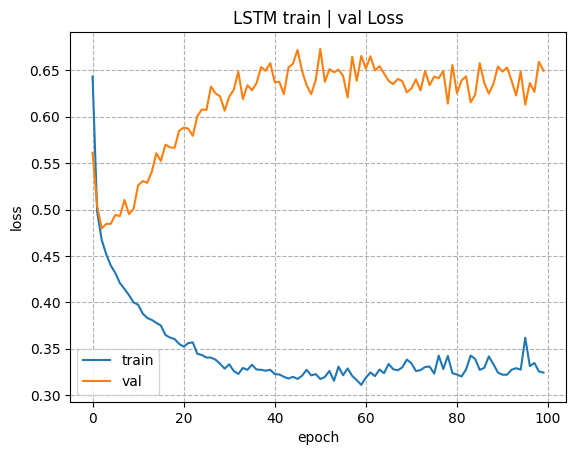

In [64]:
### 손실 곡선
plt.title("LSTM train | val Loss")
plt.plot(history.epoch, history.history["loss"])
plt.plot(history.epoch, history.history["val_loss"])
plt.legend(["train", "val"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(linestyle="--")
plt.show()

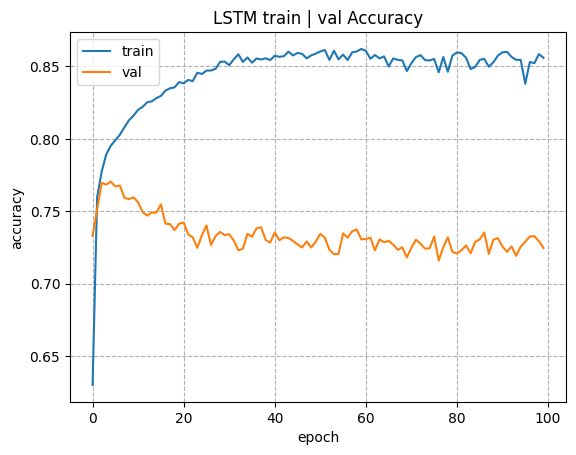

In [65]:
### 정확도 곡선
plt.title("LSTM train | val Accuracy")
plt.plot(history.epoch, history.history["accuracy"])
plt.plot(history.epoch, history.history["val_accuracy"])
plt.legend(["train", "val"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(linestyle="--")
plt.show()

### GRU 계층하기

In [ ]:
"""
<GRU(Gated Recurrent Unit, 게이트 반복 단위) 모델>
- LSTM의 4단계 게이트를 3단계로 줄여서 속도를 향상시킨 모델
- 성능은 LSTM과 유사함
"""

In [66]:
model = Sequential([
    Embedding(
        input_dim = 500,
        output_dim = 16,
        input_length = 100
    ),
    
    ### return_sequences=True : 단어단위 훈련결과의 시퀀스를 다음 LSTM으로 넘겨서 계속훈련
    #                         : LSTM 계층을 연속하여 사용할 경우에 사용
    GRU(
        units=8
    ),
    
    
    Dense(
        units=1,
        activation="sigmoid"
    )
])

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.01),
    loss = "binary_crossentropy",
    metrics=["accuracy"]
)

mc = ModelCheckpoint(
    "./model/best_GRU_model_dropout.keras",
    save_best_only=True
)

es = EarlyStopping(
    patience=5,
    restore_best_weights=True
)


In [70]:
history = model.fit(train_seq,
                    train_target,
                    validation_data=(val_seq,
                                    val_target),
                    epochs=100,
                    batch_size=32,
                    callbacks=[mc, es])

Epoch 1/100
625/625 [==============================] - 6s 10ms/step - loss: 0.4251 - accuracy: 0.7973 - val_loss: 0.4801 - val_accuracy: 0.7700
Epoch 2/100
625/625 [==============================] - 6s 10ms/step - loss: 0.4168 - accuracy: 0.8014 - val_loss: 0.4967 - val_accuracy: 0.7516
Epoch 3/100
625/625 [==============================] - 7s 11ms/step - loss: 0.4099 - accuracy: 0.8069 - val_loss: 0.4817 - val_accuracy: 0.7664
Epoch 4/100
625/625 [==============================] - 6s 9ms/step - loss: 0.4003 - accuracy: 0.8146 - val_loss: 0.5043 - val_accuracy: 0.7656
Epoch 5/100
625/625 [==============================] - 6s 9ms/step - loss: 0.3926 - accuracy: 0.8164 - val_loss: 0.4845 - val_accuracy: 0.7662
Epoch 6/100
625/625 [==============================] - 7s 12ms/step - loss: 0.3896 - accuracy: 0.8148 - val_loss: 0.5136 - val_accuracy: 0.7602


In [71]:
### 최적의 모델 읽어들여서, 훈련/검증/테스트 데이터로 성능 검증하기
best_model = keras.models.load_model("./model/best_GRU_model_dropout.keras")

train_score = best_model.evaluate(train_seq, train_target)
val_score = best_model.evaluate(val_seq, val_target)
test_score = best_model.evaluate(test_seq, test_target)

print(f"훈련 데이터   | 손실율 : {train_score[0]}, 정확도 : {train_score[1]}")
print(f"검증 데이터   | 손실율 : {val_score[0]}, 정확도 : {val_score[1]}")
print(f"테스트 데이터 | 손실율 : {test_score[0]}, 정확도 : {test_score[1]}")

### 배치사이즈 : 64
# 625/625 [==============================] - 3s 4ms/step - loss: 0.4014 - accuracy: 0.8148
# 157/157 [==============================] - 1s 4ms/step - loss: 0.4772 - accuracy: 0.7688
# 782/782 [==============================] - 3s 4ms/step - loss: 0.4650 - accuracy: 0.7730
# 훈련 데이터   | 손실율 : 0.4014440178871155, 정확도 : 0.8147500157356262
# 검증 데이터   | 손실율 : 0.47724780440330505, 정확도 : 0.7688000202178955
# 테스트 데이터 | 손실율 : 0.4649605453014374, 정확도 : 0.7729600071907043

782/782 [==============================] - 3s 4ms/step - loss: 0.4650 - accuracy: 0.7730
훈련 데이터   | 손실율 : 0.4014440178871155, 정확도 : 0.8147500157356262
검증 데이터   | 손실율 : 0.47724780440330505, 정확도 : 0.7688000202178955
테스트 데이터 | 손실율 : 0.4649605453014374, 정확도 : 0.7729600071907043


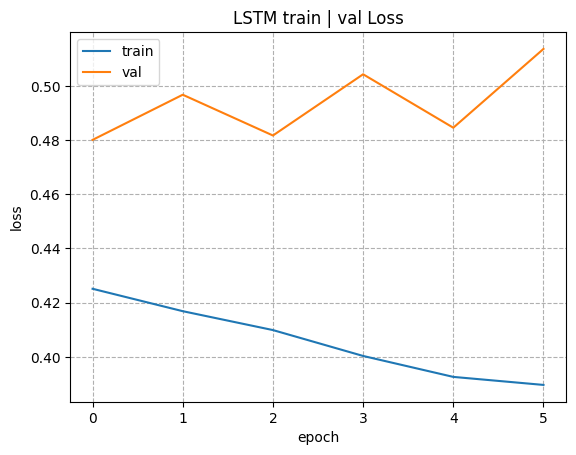

In [72]:
### 손실 곡선
plt.title("LSTM train | val Loss")
plt.plot(history.epoch, history.history["loss"])
plt.plot(history.epoch, history.history["val_loss"])
plt.legend(["train", "val"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(linestyle="--")
plt.show()

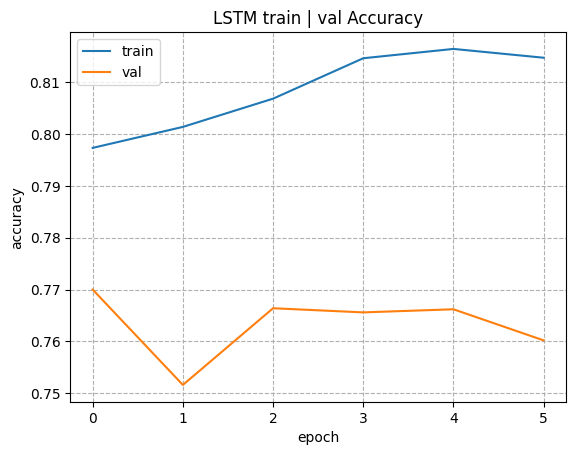

In [73]:
### 정확도 곡선
plt.title("LSTM train | val Accuracy")
plt.plot(history.epoch, history.history["accuracy"])
plt.plot(history.epoch, history.history["val_accuracy"])
plt.legend(["train", "val"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid(linestyle="--")
plt.show()

In [ ]:
model.summary()

"""
<GRU Param 계산공식>
 - GRU Param = 가중치 갯수 * (출력갯수 * (입력갯수 + 출력갯수 + 1))
             = 3          *     (8   *    (16    +   8     + 1))
             =
             
<가중치 설명>
 * 새로운 기억 셀(LSTM에서의 셀상태)
  - 현재 시점의 입력과 업데이트된 이전 상태를 바탕으로 생성된 정보를 저장하는 역할
 
 * 업데이트 게이트
  - 이전의 정보를 얼마나 유지할지 결정
  - 문장의 앞부분에서 중요한 정보가 포함되어 있다면,
    업데이트 게이트는 이 정보를 유지하도록(새로운 기억셀 업데이트) 처리하는 역할 수행
 
 * 리셋 게이트
  - 이전의 정보를 얼마나 무시할지 결정
  - 문장 중간에 나온 덜 중요한 정보는 무시할 수 있도록 처리하는 역할 수행
 
 * 중요한지 또는 무시할지는 단어들의 발생 빈도를 통해서 스스로 결정함
"""


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________
